In [1]:
# necessary libraries
using Plots
using LinearAlgebra
using ForwardDiff

# Test Function

In [2]:
# Rosenbrock function
f_rb_quad(x, y) = (1-x)^2 + 100*(4y - x^2)^2 #quadratic form
f_rb(x) = (1-x[1])^2 + 100*(4x[2] - x[1]^2)^2 # vector form
∇f_rb(x) = [2*(200x[1]^3 - 800x[1]*x[2] + x[1] - 1), -800*(x[1]^2 - 4x[2])]

∇f_rb (generic function with 1 method)

In [3]:
h(x) = ForwardDiff.hessian(f_rb, x)
h([1,1])

2×2 Array{Int64,2}:
  -398  -1600
 -1600   3200

In [4]:
function rosenplot(f; xlims=(-3,2), ylims=(-0.5,2))
    x = xlims[1]:0.01:xlims[2]
    y = ylims[1]:0.01:ylims[2]
    contour(x, y, f,
        size=(800, 250),
        framestyle=:box,
        color = cgrad(:viridis),
        levels=[2,10,50,200,500],
        clims=(0, 601),
        legend=(loc=:outertopright),
        xlims=xlims,
        ylims=ylims,
    )
end

rosenplot (generic function with 1 method)

# Newton's Method

In [5]:
function newtons_method(∇f, H, x, ε=1e-4, k_max=20) 

    xs = copy(x)'
    k, Δ = 1, fill(Inf, length(x))
    while norm(Δ) > ε && k ≤ k_max
        Δ = -H(x) \ ∇f(x)
        x += Δ
        k += 1
        xs = [xs; (x)'] 
    end
    return xs
end

newtons_method (generic function with 3 methods)

In [6]:
x0 = [-2, 1.5]
newtons_method(∇f_rb, h, x0)

7×2 Array{Float64,2}:
 -2.0        1.5
 -2.00752    1.00752
  0.966376  -1.97754
  0.966395   0.23348
  1.0        0.249718
  1.0        0.25
  1.0        0.25

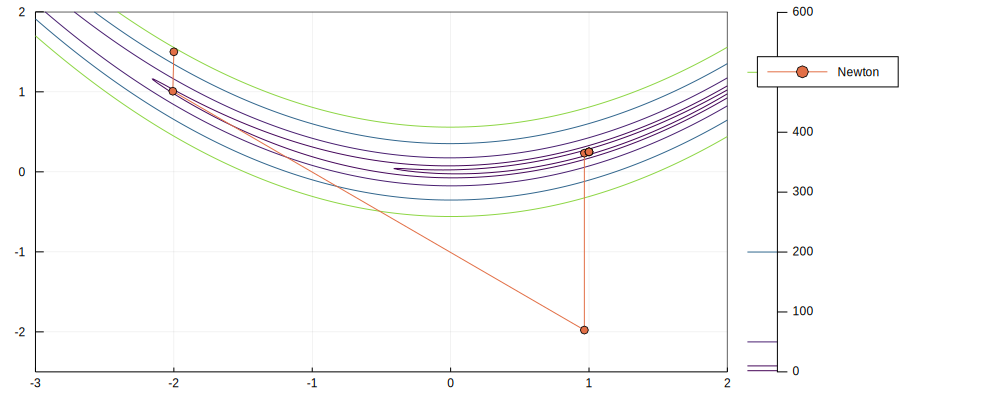

In [7]:
x0 = [-2, 1.5]
N_iter = 20
base = rosenplot(f_rb_quad, xlims=(-3, 2), ylims=(-2.5, 2))

xs = newtons_method(∇f_rb, h, x0)
plot!(base, [xs[:,1]], [xs[:,2]], m=:o, label="Newton")
plot!(size=(1000, 400))

base

# Line search

In [8]:
function line_search(f, ∇, x, d; α=10, β=1e-4, σ=0.1, max_iter=10) 
    y0, g0, y_prev, α_prev = f(x)[1], ∇(x)⋅d, NaN, 0
    αlo, αhi = NaN, NaN
    # bracket phase
    while true
        y = f(x + α*d)[1]
        if y > y0 + β*α*g0 || (!isnan(y_prev) && y ≥ y_prev) 
            αlo, αhi = α_prev, α
            break 
        end
                
        g = ∇(x + α*d)⋅d 
        if abs(g) ≤ -σ*g0
            return α 
        elseif g ≥ 0
            αlo, αhi = α, α_prev
            break 
        end
        y_prev, α_prev, α = y, α, 2α 
    end
    #@show(αlo, αhi)
    # zoom phase
    ylo = f(x + αlo*d)[1]
    n = 0
    while n < max_iter
        α = (αlo + αhi)/2
        y = f(x + α*d)[1]
        if y > y0 + β*α*g0 || y ≥ ylo #
            αhi = α 
        else
            g = ∇(x + α*d)⋅d 
            if abs(g) ≤ -σ*g0
                return α
            elseif g*(αhi - αlo) ≥ 0
                αhi = αlo 
            end
            αlo = α 
        end
        n += 1
    end
    return α #return something if it fails to find the suitable alpha
end



line_search (generic function with 1 method)

# Newton's method with line search

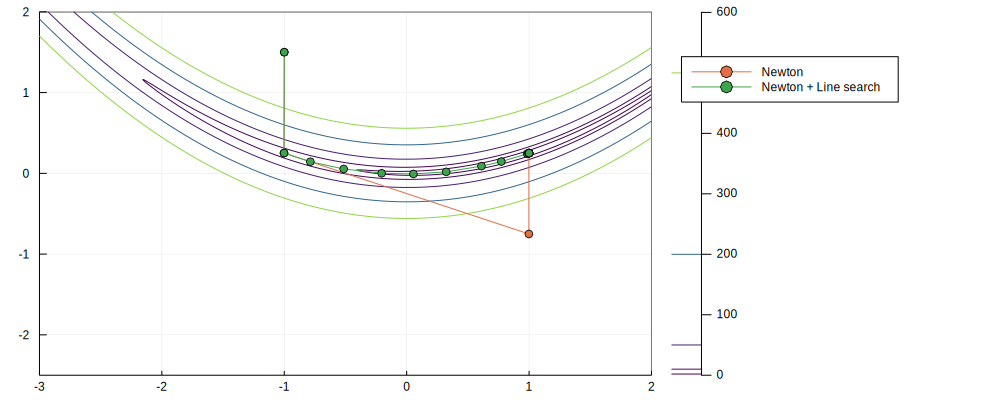

In [9]:
function newtons_method_ls(f, ∇f, H, x, ε=1e-4, k_max=20) 

    xs = copy(x)'        
    k, Δ = 1, fill(Inf, length(x))
    while norm(Δ) > ε && k ≤ k_max
        Δ = -H(x) \ ∇f(x)
        #Δ /= 20*norm(Δ) #must scale it
        α = line_search(f, ∇f, x, Δ; α=5, β=1e-6)
        if f(x+Δ) < f(x+α*Δ)
            x += Δ
        else
            x += α*Δ
        end
        k += 1
        xs = [xs; (x)'] 
    end
    return xs
end

x0 = [-1.0, 1.5]
xs1 = newtons_method(∇f_rb, h, x0)
xs2 = newtons_method_ls(f_rb, ∇f_rb, h, x0)

base = rosenplot(f_rb_quad, xlims=(-3, 2), ylims=(-2.5, 2))

plot!(base, [xs1[:,1]], [xs1[:,2]], m=:o, label="Newton")
plot!(base, [xs2[:,1]], [xs2[:,2]], m=:o, label="Newton + Line search")
plot!(size=(1000, 400))

base

# Comparison of Newton's methods with Optim.jl

In [10]:
using Optim

┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1260


In [11]:
function g!(storage, x)
    storage[1] = (2*(200x[1]^3 - 800x[1]*x[2] + x[1] - 1))
    storage[2] = (-800*(x[1]^2 - 4x[2]))
end

function h!(storage, x)
    storage[1, 1] = 1200x[1]^2 - 1600x[2] + 2
    storage[1, 2] = -1600x[1]
    storage[2, 1] = -1600x[1]
    storage[2, 2] = 3200
    
end


h! (generic function with 1 method)

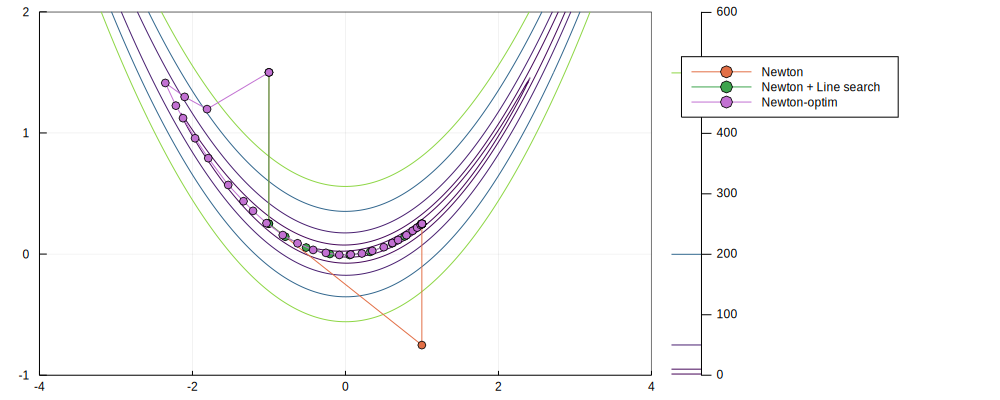

In [17]:
x0 = [-1.0, 1.5]

# Try different Newton's Method
xs1 = newtons_method(∇f_rb, h, x0)
xs2 = newtons_method_ls(f_rb, ∇f_rb, h, x0)
res = optimize(f_rb, g!, h!, x0, Newton(),
               Optim.Options(iterations = 30,
                             store_trace = true,
                             extended_trace = true)

              )
tmp = Optim.x_trace(res)
xs_optim = hcat(tmp...)

# Make the plot
base = rosenplot(f_rb_quad, xlims=(-4, 4), ylims=(-1, 2))
plot!(base, [xs1[:,1]], [xs1[:,2]], m=:o, label="Newton")
plot!(base, [xs2[:,1]], [xs2[:,2]], m=:o, label="Newton + Line search")
plot!(base, [xs_optim[1,:]], [xs_optim[2,:]], m=:o, label="Newton-optim")
plot!(size=(1000, 400))